# EE359-Coursework 4  Streaming Algorithm

## **Task1：DGIM**

DGIM is an efficient algorithm in processing large streams. When it's infeasible to store the flowing binary stream, DGIM can estimate the number of 1-bits in the window. In this coding, you're given the stream_data_dgim.txt (binary stream), and you need to implement the DGIM algorithm to count the number of 1-bits. Write code below.

First, we read the input from the given input file.

In [250]:
stream = []
with open('../input/stream-data-dgim/stream_data_dgim.txt', 'r') as f:
    for s in f.readlines():
        stream_list = s.split('\t')
        for c in stream_list:
            if c == "1" or c == "0":
                stream.append(int(c))

### 1. Set the window size to 1000, and count the number of 1-bits in the current window.

First, we define the `DGIM_Bucket` class, which records the buckets in DGIM algorithms. The `Bucket` class should support the following operations: add an element into the bucket and update the buckets (`add_bucket`), eliminate the out-of-range buckets (`step`), count the number of 1-bits in the current windows represented by the buckets (`count`).

In [251]:
import math


class DGIM_Bucket(object):
    def __init__(self, window_size, r):
        self._step = -1
        self.window_size = window_size
        self.max_size = 1 + int(math.ceil(math.log2(window_size)))
        self.r = r
        self.bucket = []
        for _ in range(self.max_size):
            self.bucket.append([])
    
    def check_update(self, size):
        if 0 <= size < self.max_size:
            return len(self.bucket[size]) > self.r
        else:
            raise AttributeError('size out of range.')
    
    def add_bucket(self, l = -1, r = -1, size = 0):
        if size < 0 or size >= self.max_size:
            return
        if l == -1 or r == -1:
            self.bucket[size].append([self._step, self._step])
        else:
            self.bucket[size].append([l, r])
        if self.check_update(size):
            new_l_pos = self.bucket[size][0][0]
            new_r_pos = self.bucket[size][1][1]
            self.bucket[size] = self.bucket[size][2:]
            self.add_bucket(new_l_pos, new_r_pos, size + 1)

    def step(self):
        self._step = (self._step + 1) % self.window_size
        first = self.max_size - 1
        while first >= 0 and self.bucket[first] == []:
            first -= 1
        if first == -1:
            return
        _, r = self.bucket[first][0]
        if r == self._step:
            del(self.bucket[first][0])
    
    def count(self, length = 0):
        count_right = self.window_size
        count_left = (self.window_size - length + 1 + self.window_size) % self.window_size
        cnt = 0
        for size in range(self.max_size - 1, -1, -1):
            for item in self.bucket[size]:
                l, r = item
                if l < count_left <= r <= count_right or count_left <= r <= count_right < l or count_right < l < count_left <= r or r <= count_right < l < count_left:
                    cnt += (2 ** (size - 1))
                elif count_left <= l <= r <= count_right or r <= count_right < count_left <= l or count_right < count_left <= l <= r or l <= r <= count_right < count_left:
                    cnt += 2 ** size
        return cnt

Then, we implement a class `DGIM` which provides two operations:
1. signal(s): the DGIM receives a signal s (s should be 0 or 1);
2. count(length = 0): the DGIM counts the number of 1s in the window of length `length`, where `length <= window_size`.

In [252]:
class DGIM(object):
    def __init__(self, window_size, r = 2):
        super(DGIM, self).__init__()
        self.window_size = window_size
        self.bucket = DGIM_Bucket(window_size, r)
    
    def signal(self, s):
        assert s == 0 or s == 1
        self.bucket.step()
        if s == 1:
            self.bucket.add_bucket()
    
    def count(self, length = 0):
        assert length <= self.window_size
        return self.bucket.count(length)

Then, we write a `DGIM_experiment` to conduct experiments conveniently.

In [253]:
def DGIM_experiment(window_size = 1000, count_range = 1000, r = 2):
    assert count_range <= window_size
    from time import perf_counter
    start_time = perf_counter()
    solver = DGIM(window_size = window_size, r = r)
    res = []
    for signal in stream:
        solver.signal(signal)
        res.append(solver.count(length = count_range))
    print('Window size {}, r {}, counting range {}, execution time: {:.3f} seconds'.format(window_size, r, count_range, perf_counter() - start_time))
    return res

Then, we count the number of 1s in the current window, and store the result in `res_1000` array.

In [254]:
res_1000 = DGIM_experiment(1000, 1000, 2)

Window size 1000, r 2, counting range 1000, execution time: 0.653 seconds


### 2. With the window size 1000, count the number of 1-bits in the last 500 and 200 bits of the bitstream.

The results are stored in `result_500` array and `result_200` respectively.

In [255]:
res_500 = DGIM_experiment(1000, 500, 2)
res_200 = DGIM_experiment(1000, 200, 2)

Window size 1000, r 2, counting range 500, execution time: 0.609 seconds
Window size 1000, r 2, counting range 200, execution time: 0.575 seconds


### 3. Write a function that accurately counts the number of 1-bits in the current window. Caculate the accuracy of your own DGIM algorithm and compare the running time difference.

We implement brute-force algorithm to accurately count the number of 1-bits in the current window.

In [256]:
def DGIM_bf_experiment(window_length):
    cur_window = []
    res = []
    cnt = 0
    start_time = perf_counter()
    for signal in stream:
        if len(cur_window) == window_length:
            cnt -= cur_window[0]
            del(cur_window[0])
        cur_window.append(signal)
        cnt += signal
        res.append(cnt)
    print('Counting range {}, execution time: {:.3f} seconds'.format(window_length, perf_counter() - start_time))
    return res

Then, we count the number of 1-bits in the window of size 1000, 500 and 200. The results are stored in `res_1000_accurate`, `res_500_accurate` and `res_200_accurate` respectively.

In [257]:
res_1000_accurate = DGIM_bf_experiment(1000)
res_500_accurate = DGIM_bf_experiment(500)
res_200_accurate = DGIM_bf_experiment(200)

Counting range 1000, execution time: 0.026 seconds
Counting range 500, execution time: 0.022 seconds
Counting range 200, execution time: 0.020 seconds


Now, we can calculate the metrics:
1. Mean error rate: the average of sample error rate defined as follows.
   $$
   \frac{\left|res - res_{acc}\right|}{res_{acc} + \varepsilon}
   $$
   where $\varepsilon = 10^{-10}$ to prevent divide-0 errors.
2. Max error rate: the maximum of sample error rate.

In [258]:
import numpy as np
eps = 1e-10
error_1000 = np.abs(np.array(res_1000) - np.array(res_1000_accurate)) / (np.array(res_1000_accurate) + eps)
error_500 = np.abs(np.array(res_500) - np.array(res_500_accurate)) / (np.array(res_500_accurate) + eps)
error_200 = np.abs(np.array(res_200) - np.array(res_200_accurate)) / (np.array(res_200_accurate) + eps)
print('DGIM with window size {} and count range {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 1000, error_1000.mean(), error_1000.max()))
print('DGIM with window size {} and count range {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 500, error_500.mean(), error_500.max()))
print('DGIM with window size {} and count range {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 200, error_200.mean(), error_200.max()))

DGIM with window size 1000 and count range 1000: mean error rate 0.18402, max error rate: 0.54306
DGIM with window size 1000 and count range 500: mean error rate 0.25618, max error rate: 1.00000
DGIM with window size 1000 and count range 200: mean error rate 0.45726, max error rate: 1.65217


**Speed**: Therefore, the DGIM algorithm runs approximately 20x slower than the brute-force algorithm. Since $20 \sim O(\log_2 window\_size)$. The speed is in a reasonable range.

**Accuracy**: The error rate of DGIM algorithm is lowest when $window\_size = count\_range$. For $window\_size = 1000$ and $count\_range = 1000$, the mean error rate is only $18.4\%$; while for $window\_size = 1000$ and $count\_range = 500$, the mean error rate is $25.6\%$; and for $window\_size = 1000$ and $count\_range = 200$, the mean error rate increases to even $45.7\%$.

From class we learn that the error rate is bounded by $\frac{2^{r-1}}{2^r-1}$ where $2^r$ is the max bucket size. But actually, this error rate is slightly bigger than $50\%$, especially when $r$ is slow, the error rate may even comes to $100\%$. This conclusion is only valid when $window\_size = count\_range$. Therefore the mean error rate and max error rate when $window\_size = 1000$ and $count\_range = 1000$ is reasonable.

When $window\_size > count\_range$, the bound no longer holds, since it is possible that $count\_range < 2^r \leq window\_size$. Therefore, our results is also reasonable.

**Conclusion**: From this we can conclude that, the DGIM runs approximately $\sim \log_2 window\_size$-x slower than the brute-force algorithm, but it saves the space complexity. The error rate of DGIM algorithm is lowest when $window\_size = count\_range$, since under this circumstance, it is bounded by $\frac{2^{r-1}}{2^r-1}$.

**Further Experiments**: In class, the teacher also says that the increase of parameter $r$ may reduce the error rate, and also make DGIM run slower. Therefore, we design the following experiments to verify it.

In [259]:
res_1000_r_5 = DGIM_experiment(window_size = 1000, r = 5)
res_1000_r_10 = DGIM_experiment(window_size = 1000, r = 10)
res_1000_r_20 = DGIM_experiment(window_size = 1000, r = 20)

error_1000_r_5 = np.abs(np.array(res_1000_r_5) - np.array(res_1000_accurate)) / (np.array(res_1000_accurate) + eps)
error_1000_r_10 = np.abs(np.array(res_1000_r_10) - np.array(res_1000_accurate)) / (np.array(res_1000_accurate) + eps)
error_1000_r_20 = np.abs(np.array(res_1000_r_20) - np.array(res_1000_accurate)) / (np.array(res_1000_accurate) + eps)

print('DGIM with window size {} and r {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 2, error_1000.mean(), error_1000.max()))
print('DGIM with window size {} and r {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 5, error_1000_r_5.mean(), error_1000_r_5.max()))
print('DGIM with window size {} and r {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 10, error_1000_r_10.mean(), error_1000_r_10.max()))
print('DGIM with window size {} and r {}: mean error rate {:.5f}, max error rate: {:.5f}'.format(1000, 20, error_1000_r_20.mean(), error_1000_r_20.max()))

Window size 1000, r 5, counting range 1000, execution time: 1.179 seconds
Window size 1000, r 10, counting range 1000, execution time: 1.842 seconds
Window size 1000, r 20, counting range 1000, execution time: 2.831 seconds
DGIM with window size 1000 and r 2: mean error rate 0.18402, max error rate: 0.54306
DGIM with window size 1000 and r 5: mean error rate 0.05468, max error rate: 0.17778
DGIM with window size 1000 and r 10: mean error rate 0.02791, max error rate: 0.08889
DGIM with window size 1000 and r 20: mean error rate 0.01458, max error rate: 0.04469


The results have verified the conclusion we learned in class: the increase of $r$ may reduce the error rate, and also make DGIM run slower. Hence, there is a **trade-off** between performance and speed in DGIM algorithm determined by parameter $r$.

## **Task2: Bloom Filter**

A Bloom filter is a space-efficient probabilistic data structure. Here the task is to implement a bloom filter by yourself. 

### Data loading:

From the NLTK (Natural Language ToolKit) library, we import a large list of English dictionary words, commonly used by the very first spell-checking programs in Unix-like operating systems.

In [260]:
import nltk
from nltk.corpus import words
word_list = words.words()

Then we load another dataset from the NLTK Corpora collection: movie_reviews.

The movie reviews are categorized between positive and negative, so we construct a list of words (usually called bag of words) for each category.

In [261]:
from nltk.corpus import movie_reviews

neg_reviews = []
pos_reviews = []

for fileid in movie_reviews.fileids('neg'):
  neg_reviews.extend(movie_reviews.words(fileid))
for fileid in movie_reviews.fileids('pos'):
  pos_reviews.extend(movie_reviews.words(fileid))

Here we get a data stream (word_list) and 2 query lists (neg_reviews and pos_reviews).

### 1. Write a function that accurately determines whether each word in neg_reviews and pos_reviews belongs to word_list.

We write a function `word_in_list_accurate(words, word_list)` to determine whether each word in words is in word_list.

In [262]:
def word_in_list_accurate(words, word_list, text):
    from time import perf_counter
    from tqdm import tqdm
    start_time = perf_counter()
    res = []
    for word in tqdm(words):
        if word in word_list:
            res.append(True)
        else:
            res.append(False)
    print('Running time on {}: {:.3f} seconds'.format(text, perf_counter() - start_time))
    return res

Therefore, we just need to call the function to get the accurate results, namely `pos_gt` and `neg_gt`.

In [263]:
pos_gt = word_in_list_accurate(pos_reviews, word_list, "positive reviews")
neg_gt = word_in_list_accurate(neg_reviews, word_list, "negative reviews")

  0%|          | 112/751256 [00:00<22:38, 552.97it/s]

Running time on positive reviews: 1532.498 seconds


100%|██████████| 751256/751256 [23:13<00:00, 539.16it/s]

Running time on negative reviews: 1393.381 seconds


 ### 2. Implement the bloom filter by yourself and add all words in word_list in your bloom filter. Compare the running time difference between linear search on a list and multiple hash computations in a Bloom filter.

We can implement the bloom filter class `BloomFilter(k, m)` as follows, where `k` is the number of hash functions, and `m` is the modulo number. We use `md5()` as base hash function and add different prefixes and suffixes to create different hash functions.

In [267]:
import math
import random
import numpy as np
from hashlib import md5


class BloomFilter(object):
    def __init__(self, k, m):
        super(BloomFilter, self).__init__()
        self.m = m
        self.k = k
        self.add_str = []
        for _ in range(k):
            length = random.randint(10, 30)
            s = ""
            for _ in range(length):
                s = s + chr(random.randint(0, 255))
            self.add_str.append(s)
        self.record = np.zeros(self.m, dtype = np.bool)
    
    def get_hash(self, word, k):
        word = self.add_str[k] + word + self.add_str[k]
        return int(md5(word.encode('utf-8')).hexdigest(), 16) % self.m

    def add_word(self, word):
        for k in range(self.k):
            self.record[self.get_hash(word, k)] = 1
    
    def check_word(self, word):
        for k in range(self.k):
            if self.record[self.get_hash(word, k)] == 0:
                return False
        return True

Then, we can create `bloom_filter_experiment(k, m)` function for convenience.

In [282]:
def bloom_filter_experiment(words, word_list, text, k, m):
    from time import perf_counter
    bf = BloomFilter(k, m)
    start_time = perf_counter()
    res = []
    for word in word_list:
        bf.add_word(word)
    for word in words:
        res.append(bf.check_word(word))
    print('Bloom filter running time on {}: {:.3f} seconds'.format(text, perf_counter() - start_time))
    return res

Then, we use $k=4, m = 10000019$ ($m$ is a prime number) in the experiment.

In [283]:
pos_res = bloom_filter_experiment(pos_reviews, word_list, "positive reviews", k = 4, m = 10000019)
neg_res = bloom_filter_experiment(neg_reviews, word_list, "negative reviews", k = 4, m = 10000019)

Bloom filter running time on positive reviews: 17.929 seconds
Bloom filter running time on negative reviews: 16.259 seconds


**Running Time Comparison**. For positive reviews, the bloom filter can finish executing in $18.621$ seconds, while the brute-force linear searching on list takes $1532.498$ seconds. For negative reviews, the bloom filter can finish executing in $17.541$ seconds, while the brute-force linear searching on list takes $1393.381$ seconds. Therefore, the bloom filter is ~80x faster than the brute-force linear searching on list. Hence, it is very efficient.

### 3. Use different bit array length ‘m’ and number of hash functions ‘k’ to implement the bloom filter algorithm. Then compare the impact of different m and k on the false positive rate.

Then, we calculate false positive rate according to the results and the ground-truth.

In [284]:
def calc_false_positive_rate(res, gt):
    assert len(res) == len(gt)
    fp = 0
    for i in range(len(res)):
        if res[i] and not gt[i]:
            fp += 1
    return fp / len(res)

Then, we can evaluate the false positive rate of our bloom filter.

In [285]:
print('False positive rate on positive reviews (m = {}, k = {}): {:.8f}'.format(10000019, 5, calc_false_positive_rate(pos_res, pos_gt)))
print('False positive rate on negative reviews (m = {}, k = {}): {:.8f}'.format(10000019, 5, calc_false_positive_rate(neg_res, neg_gt)))

False positive rate on positive reviews (m = 10000019, k = 5): 0.00000240
False positive rate on negative reviews (m = 10000019, k = 5): 0.00000000


The results has shown that the Bloon Filter has a relatively low false positive rate, which means it is effective.

Then, we conduct further experiments: we select $m$ from $\{10007, 100003, 1000003, 10000019, 100000007, 1000000007\}$, and select $k$ from $\{1, 2, 3, 4, 5, 6, 7, 8, 9\}$ to compare the false positive rate under different $m$ and $k$.

In [288]:
m_list = [10007, 100003, 1000003, 10000019, 100000007, 1000000007]
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
pos_results = np.zeros((len(m_list), len(k_list)))
neg_results = np.zeros((len(m_list), len(k_list)))
for i, m in enumerate(m_list):
    for j, k in enumerate(k_list):
        pos_res_t = bloom_filter_experiment(pos_reviews, word_list, "positive reviews", k = k, m = m)
        neg_res_t = bloom_filter_experiment(neg_reviews, word_list, "negative reviews", k = k, m = m)
        pos_results[i, j] = calc_false_positive_rate(pos_res_t, pos_gt)
        neg_results[i, j] = calc_false_positive_rate(neg_res_t, neg_gt)        

Bloom filter running time on positive reviews: 5.856 seconds
Bloom filter running time on negative reviews: 5.477 seconds
Bloom filter running time on positive reviews: 10.977 seconds
Bloom filter running time on negative reviews: 10.038 seconds
Bloom filter running time on positive reviews: 16.005 seconds
Bloom filter running time on negative reviews: 14.804 seconds
Bloom filter running time on positive reviews: 20.963 seconds
Bloom filter running time on negative reviews: 19.469 seconds
Bloom filter running time on positive reviews: 26.346 seconds
Bloom filter running time on negative reviews: 23.990 seconds
Bloom filter running time on positive reviews: 31.612 seconds
Bloom filter running time on negative reviews: 29.074 seconds
Bloom filter running time on positive reviews: 36.923 seconds
Bloom filter running time on negative reviews: 33.784 seconds
Bloom filter running time on positive reviews: 42.170 seconds
Bloom filter running time on negative reviews: 38.222 seconds
Bloom filt

Then, we can plot the results for better visualizations.

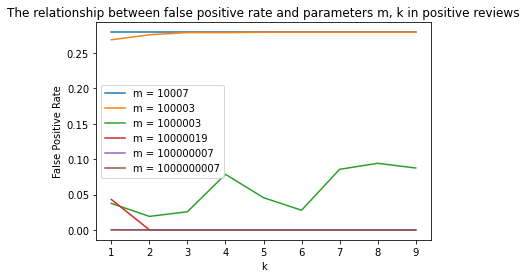

In [289]:
import matplotlib.pyplot as plt
x = range(1, 10)
plt.plot(x, pos_results[0, :], label = 'm = 10007')
plt.plot(x, pos_results[1, :], label = 'm = 100003')
plt.plot(x, pos_results[2, :], label = 'm = 1000003')
plt.plot(x, pos_results[3, :], label = 'm = 10000019')
plt.plot(x, pos_results[4, :], label = 'm = 100000007')
plt.plot(x, pos_results[5, :], label = 'm = 1000000007')
plt.legend()
plt.xlabel("k")
plt.ylabel("False Positive Rate") 
plt.title("The relationship between false positive rate and parameters m, k in positive reviews")
plt.show()

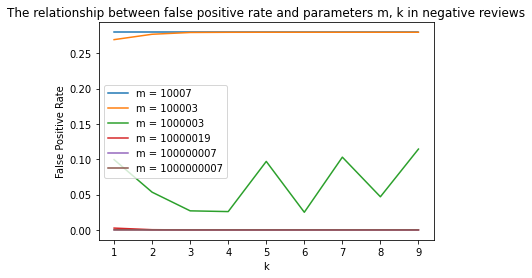

In [290]:
x = range(1, 10)
plt.plot(x, neg_results[0, :], label = 'm = 10007')
plt.plot(x, neg_results[1, :], label = 'm = 100003')
plt.plot(x, neg_results[2, :], label = 'm = 1000003')
plt.plot(x, neg_results[3, :], label = 'm = 10000019')
plt.plot(x, neg_results[4, :], label = 'm = 100000007')
plt.plot(x, neg_results[5, :], label = 'm = 1000000007')
plt.legend()
plt.xlabel("k")
plt.ylabel("False Positive Rate") 
plt.title("The relationship between false positive rate and parameters m, k in negative reviews")
plt.show()

**Conclusion**: When $m$ is large enough, the false positive rate of the bloom filter will decrease to nearly 0. For some small $m$, it seems $k \in [3, 6]$ might be a good choice since it has a low false positive rate.

**The impact of $m$**: Generally, the larger the $m$ is, the lower the false positive rate will be, but it will also takes more time.

**The impact of $k$**: Generally, the larger the $k$ is, the lower the false positive rate will be, but it will also takes more time. Since there is some stochastic process in the bloom filter, the conclusion does not always hold (for example, $m = 1000003$).

## **Task3: Count-Min sketch**



In computing, the count–min sketch (CM sketch) is a probabilistic data structure that serves as a frequency table of events in a stream of data. 

Here we use the query stream (neg_reviews or pos_reviews) from task 2.

### 1. Write a function that accurately counts the occurrence times of each word in neg_reviews or pos_reviews.

First, we combine the words of `pos_reviews` and `neg_reviews` together to create the word set.

In [291]:
word_set = list(set(pos_reviews + neg_reviews))

Then, we write a function `count_accurate_occurence(words)` to count the accurate occurences of each word in word set.

In [292]:
def count_accurate_occurrence(words, text):
    from time import perf_counter
    from tqdm import tqdm
    occ = {}
    res = []
    start_time = perf_counter()
    for word in tqdm(words):
        occ[word] = occ.get(word, 0) + 1
    for word in tqdm(word_set):
        res.append(occ.get(word, 0))
    print('Brute-force running time on {}: {:.3f} seconds'.format(text, perf_counter() - start_time))
    return res

Therefore, we can get the accurate results of the occurence times of each word in `neg_reviews` and `pos_reviews`.

In [293]:
pos_occ_gt = count_accurate_occurrence(pos_reviews, "positive reviews")
neg_occ_gt = count_accurate_occurrence(neg_reviews, "negative reviews")

 16%|█▌        | 117518/751256 [00:00<00:00, 1175099.87it/s]

Brute-force running time on positive reviews: 0.586 seconds


100%|██████████| 39768/39768 [00:00<00:00, 805952.30it/s]

Brute-force running time on negative reviews: 0.567 seconds


### 2. Implement the Count-Min sketch by yourself. Set different width w and depth d of the internal data structure of CM-Sketch. Compare the influence of different w and d on the error.

We can implement the Count-Min sketch class `CMSketch(w, d)` as follows, where `w` is the width of the table, and `d` is the depth of the table. We use `md5()` as base hash function and add different prefixes and suffixes to create different hash functions.

In [304]:
import math
import random
import numpy as np
from hashlib import md5


class CMSketch(object):
    def __init__(self, w, d):
        super(CMSketch, self).__init__()
        self.w = w
        self.d = d
        self.add_str = []
        for _ in range(d):
            length = random.randint(10, 30)
            s = ""
            for _ in range(length):
                s = s + chr(random.randint(0, 255))
            self.add_str.append(s)
        self.record = np.zeros((self.w, self.d), dtype = np.int)
    
    def get_hash(self, word, d):
        word = self.add_str[d] + word + self.add_str[d]
        return int(md5(word.encode('utf-8')).hexdigest(), 16) % self.w

    def add_word(self, word):
        for d in range(self.d):
            self.record[self.get_hash(word, d), d] += 1
    
    def get_occurrence(self, word):
        occ = -1
        for d in range(self.d):
            if occ == -1:
                occ = self.record[self.get_hash(word, d), d]
            else:
                occ = min(occ, self.record[self.get_hash(word, d), d])
        return occ

Then, we can create `CMSketch_experiment` function for convenience.

In [305]:
def CMSketch_experiment(words, text, w, d):
    from time import perf_counter
    from tqdm import tqdm
    cm = CMSketch(w = w, d = d)
    start_time = perf_counter()
    res = []
    for word in words:
        cm.add_word(word)
    for word in word_set:
        res.append(cm.get_occurrence(word))
    print('CM Sketch running time on {}: {:.3f} seconds'.format(text, perf_counter() - start_time))
    return res

Then, we use $w = 10000019, d = 5$ for the experiments.

In [306]:
pos_occ_res = CMSketch_experiment(pos_reviews, "positive reviews", 10000019, 5)
neg_occ_res = CMSketch_experiment(neg_reviews, "negative reviews", 10000019, 5)

CM Sketch running time on positive reviews: 17.868 seconds
CM Sketch running time on negative reviews: 16.014 seconds


Then, we can calculate some metrics based on the ground-truth and the counting results. Here we provide two metrics: the mean error rate and the max error rate, which is introduced before in Task 1.

In [307]:
def calc_error_rate(occ_res, occ_gt):
    eps = 1e-10
    err = np.abs((np.array(occ_res) - np.array(occ_gt))) / (np.array(occ_gt) + eps)
    return err.mean(), err.max()

We can calculate the previous metrics by calling `calc_error_rate(res, gt)`.

In [308]:
pos_mean_err_rate, pos_max_err_rate = calc_error_rate(pos_occ_res, pos_occ_gt)
neg_mean_err_rate, neg_max_err_rate = calc_error_rate(neg_occ_res, neg_occ_gt)
print('Mean error rate and max error rate on positive reviews (w = {}, d = {}): {:.8f}, {:.8f}'.format(10000019, 5, pos_mean_err_rate, pos_max_err_rate))
print('Mean error rate and max error rate on negative reviews (w = {}, d = {}): {:.8f}, {:.8f}'.format(10000019, 5, neg_mean_err_rate, neg_max_err_rate))

Mean error rate and max error rate on positive reviews (w = 10000019, d = 5): 0.00000000, 0.00000000
Mean error rate and max error rate on negative reviews (w = 10000019, d = 5): 0.00000000, 0.00000000


Then, we conduct further experiments: we select $m$ from $\{10007, 100003, 1000003, 10000019, 100000007\}$, and select $k$ from $\{2, 3, 4, 5, 6, 7\}$ to compare the mean error rate under different $m$ and $k$.

In [310]:
w_list = [10007, 100003, 1000003, 10000019, 100000007]
d_list = [2, 3, 4, 5, 6, 7]
pos_occ_results_mean = np.zeros((len(w_list), len(d_list)))
neg_occ_results_mean = np.zeros((len(w_list), len(d_list)))
pos_occ_results_max = np.zeros((len(w_list), len(d_list)))
neg_occ_results_max = np.zeros((len(w_list), len(d_list)))
for i, w in enumerate(w_list):
    for j, d in enumerate(d_list):
        pos_occ_res_t = CMSketch_experiment(pos_reviews, "positive reviews", w = w, d = d)
        neg_occ_res_t = CMSketch_experiment(neg_reviews, "negative reviews", w = w, d = d)
        pos_mean_err_rate, pos_max_err_rate = calc_error_rate(pos_occ_res_t, pos_occ_gt)
        neg_mean_err_rate, neg_min_err_rate = calc_error_rate(neg_occ_res_t, neg_occ_gt)
        pos_occ_results_mean[i, j] = pos_mean_err_rate
        neg_occ_results_mean[i, j] = neg_mean_err_rate
        pos_occ_results_max[i, j] = pos_max_err_rate
        neg_occ_results_max[i, j] = neg_max_err_rate

CM Sketch running time on positive reviews: 7.189 seconds
CM Sketch running time on negative reviews: 6.488 seconds
CM Sketch running time on positive reviews: 10.492 seconds
CM Sketch running time on negative reviews: 9.371 seconds
CM Sketch running time on positive reviews: 13.762 seconds
CM Sketch running time on negative reviews: 12.478 seconds
CM Sketch running time on positive reviews: 17.246 seconds
CM Sketch running time on negative reviews: 15.406 seconds
CM Sketch running time on positive reviews: 20.285 seconds
CM Sketch running time on negative reviews: 18.535 seconds
CM Sketch running time on positive reviews: 23.725 seconds
CM Sketch running time on negative reviews: 21.843 seconds
CM Sketch running time on positive reviews: 7.175 seconds
CM Sketch running time on negative reviews: 6.508 seconds
CM Sketch running time on positive reviews: 10.466 seconds
CM Sketch running time on negative reviews: 9.363 seconds
CM Sketch running time on positive reviews: 13.712 seconds
CM 

Then, we can plot the results for better visualizations.

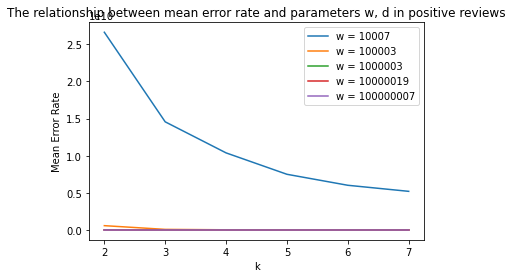

In [311]:
import matplotlib.pyplot as plt
x = range(2, 8)
plt.plot(x, pos_occ_results_mean[0, :], label = 'w = 10007')
plt.plot(x, pos_occ_results_mean[1, :], label = 'w = 100003')
plt.plot(x, pos_occ_results_mean[2, :], label = 'w = 1000003')
plt.plot(x, pos_occ_results_mean[3, :], label = 'w = 10000019')
plt.plot(x, pos_occ_results_mean[4, :], label = 'w = 100000007')
plt.legend()
plt.xlabel("k")
plt.ylabel("Mean Error Rate") 
plt.title("The relationship between mean error rate and parameters w, d in positive reviews")
plt.show()

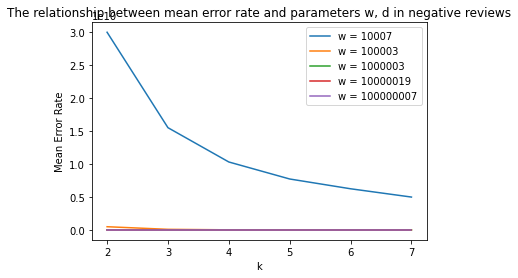

In [313]:
import matplotlib.pyplot as plt
x = range(2, 8)
plt.plot(x, neg_occ_results_mean[0, :], label = 'w = 10007')
plt.plot(x, neg_occ_results_mean[1, :], label = 'w = 100003')
plt.plot(x, neg_occ_results_mean[2, :], label = 'w = 1000003')
plt.plot(x, neg_occ_results_mean[3, :], label = 'w = 10000019')
plt.plot(x, neg_occ_results_mean[4, :], label = 'w = 100000007')
plt.legend()
plt.xlabel("k")
plt.ylabel("Mean Error Rate") 
plt.title("The relationship between mean error rate and parameters w, d in negative reviews")
plt.show()

**Conclusion**: When $w$ is large enough, the mean error rate and the max error rate of the CM Sketch will decrease to nearly 0. For some small $w$, it seems $d \in []$ might be a good choice since it has a low mean error rate and max error rate.

**The impact of $w$**: Generally, the larger the $w$ is, the lower the mean error rate and max error rate will be, but it will also takes more space.

**The impact of $d$**: Generally, the larger the $d$ is, the lower the mean error rate and max error rate will be, but it will also takes more time.